In [328]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Seq from real

In [329]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))
#sorted(glob.glob("/home/beans/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_351',
 '/media/beans/ssd/bespoke_logging/run_352',
 '/media/beans/ssd/bespoke_logging/run_353',
 '/media/beans/ssd/bespoke_logging/run_354',
 '/media/beans/ssd/bespoke_logging/run_355',
 '/media/beans/ssd/bespoke_logging/run_356',
 '/media/beans/ssd/bespoke_logging/run_357',
 '/media/beans/ssd/bespoke_logging/run_358',
 '/media/beans/ssd/bespoke_logging/run_359',
 '/media/beans/ssd/bespoke_logging/run_359a',
 '/media/beans/ssd/bespoke_logging/run_359b',
 '/media/beans/ssd/bespoke_logging/run_360',
 '/media/beans/ssd/bespoke_logging/run_361',
 '/media/beans/ssd/bespoke_logging/run_362',
 '/media/beans/ssd/bespoke_logging/run_363',
 '/media/beans/ssd/bespoke_logging/run_364',
 '/media/beans/ssd/bespoke_logging/run_365',
 '/media/beans/ssd/bespoke_logging/run_366',
 '/media/beans/ssd/bespoke_logging/run_367',
 '/media/beans/ssd/bespoke_logging/run_368',
 '/media/beans/ssd/bespoke_logging/run_369',
 '/media/beans/ssd/bespoke_logging/run_370',
 '/media

In [330]:
#run_id = "run_382" # out sabq to pow to grade
#run_id = "run_383" # back from grade, 214, madrona, sunny
#run_id = "run_392" # back from nabq, creeper on ev, sunny
#run_id = "run_396" # back from nabq, on 213, cloudy
#run_id = "run_402" # back from nabq, on 213, sunny
#run_id = "run_404" # # out to end sabq
#run_id = "run_412" # back from end nabq, sunny

#run_id = "run_492" # to mid nabq and back, sunny, a few map blips at due south
#run_id = "run_492a" # out ev
#run_id = "run_492d" # out sabq

#run_id = "run_494" # to mid nabq and back via timber trail, silver falls highway, quall, madrona, ev. Cloudy.  
run_id = "run_498"

run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
#run_path = f"/home/beans/bespoke_logging/{run_id}"

model_stem = "8.18_avg" #"8.18_e34"

In [331]:
aux_paths = sorted(glob.glob(f"{run_path}/aux/*"))
img_paths = sorted(glob.glob(f"{run_path}/img/*"))
car_state_paths = sorted(glob.glob(f"{run_path}/car_state/*"))
m = min([len(aux_paths), len(img_paths), len(car_state_paths)])
len(aux_paths), len(img_paths), len(car_state_paths), m

(43431, 43431, 43431, 43431)

In [332]:
s, e = 0, -100 #-100 #9400, 11_400 #4000
#e = m

aux = np.stack([np.load(f) for f in aux_paths[s:e]]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))[s:e]]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[s:e]])#.astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape, aux.shape, car_state.shape

((43331, 100, 640, 3), (43331, 5), (43331, 16))

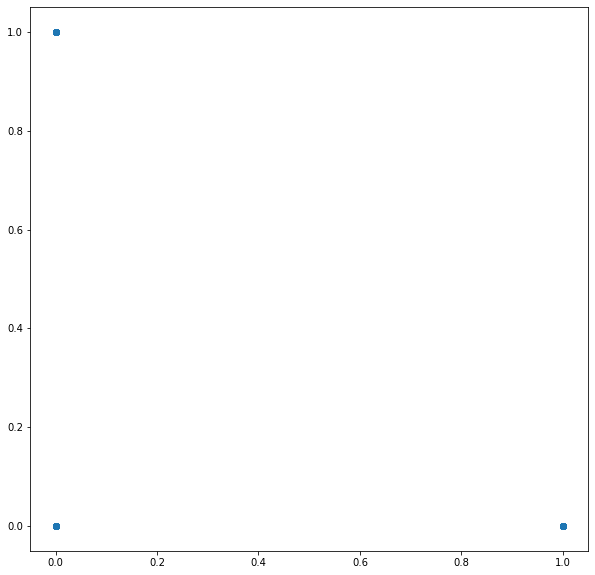

In [333]:
plt.figure(figsize=(10,10))

lats, lons = car_state[:,-2], car_state[:,-1]

plt.scatter(lons, lats)

In [334]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

In [335]:
headings = []
for i in range(10, len(lats), 5):
    prev_lat, prev_lon = lats[i-10], lons[i-10]
    fwd_azimuth, back_azimuth, distance = geodesic.inv(prev_lon, prev_lat, lons[i], lats[i]) 
    headings.append(fwd_azimuth)

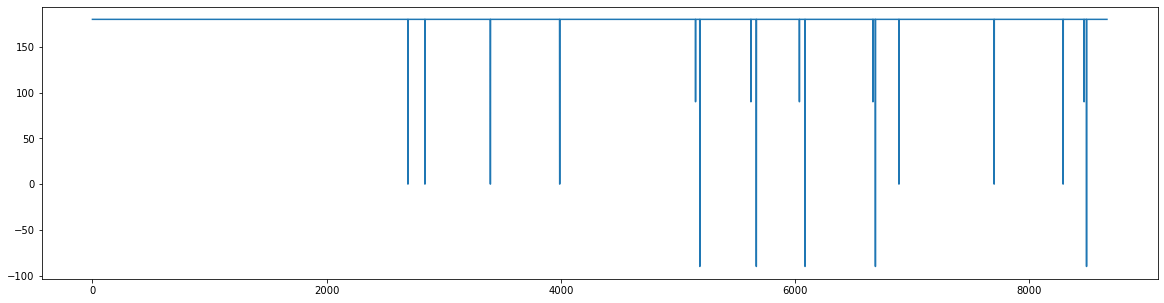

In [336]:
plt.figure(figsize=(20,5))
plt.plot(headings)

In [337]:
from map_utils import *
from big_map_utils import *

In [338]:
big_lats, big_lons, way_ids = get_big_map()

In [339]:
vehicle_heading = np.radians(240) # fake number
LON_MULT = get_lon_mult(big_lats.mean())
ix = 37_000
small_map = get_map(big_lats, big_lons*LON_MULT, way_ids, lats[ix], lons[ix]*LON_MULT, vehicle_heading+np.pi/2, CLOSE_BUFFER)

In [340]:
big_lats.mean()

44.99004223687407

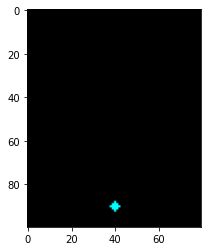

In [341]:
plt.imshow(small_map)

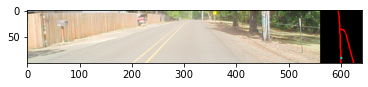

In [342]:
plt.imshow(img[ix])

In [343]:
commanded_torque = car_state[:, 7]

array([2.2000e+01, 8.7000e+01, 9.4290e+03, 3.3709e+04, 5.0000e+01,
       7.0000e+00, 7.0000e+00, 3.0000e+00, 7.0000e+00, 1.0000e+01])

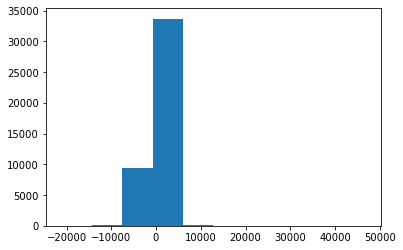

In [344]:
plt.hist(commanded_torque)[0]

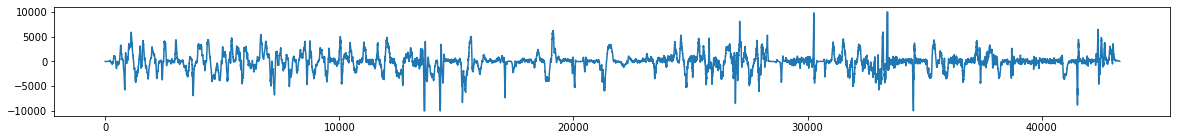

In [345]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

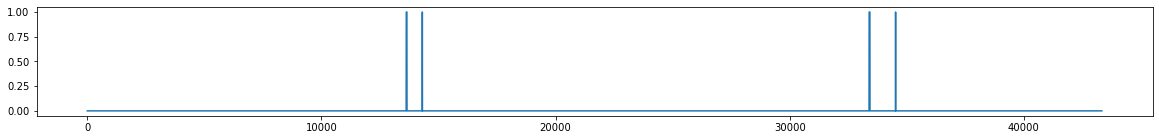

In [346]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([2.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+00, 2.5600e+02,
       4.3029e+04, 3.3000e+01, 3.0000e+00, 0.0000e+00, 1.0000e+00])

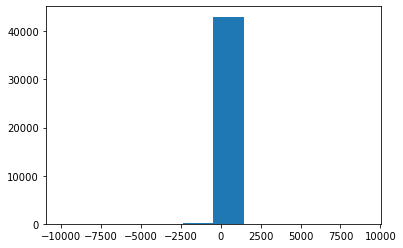

In [347]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -10_000, 10_000))[0]

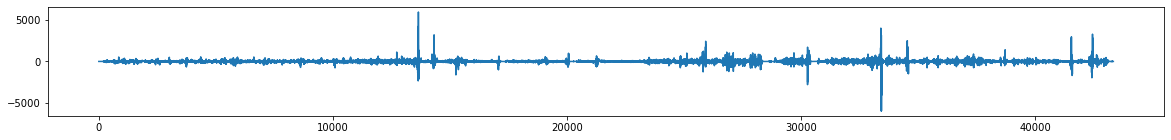

In [348]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -6000, 6000))

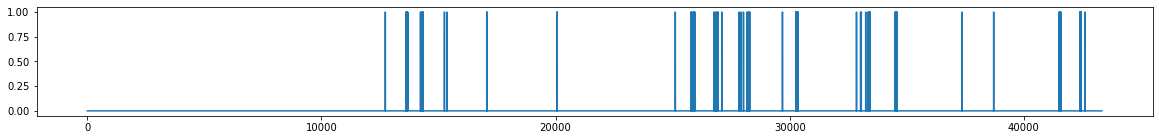

In [349]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

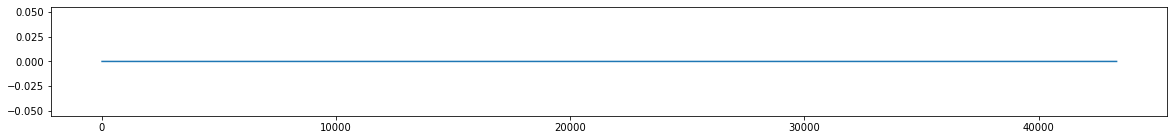

In [350]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

In [351]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

In [352]:
#plt.imshow(img[15_750])

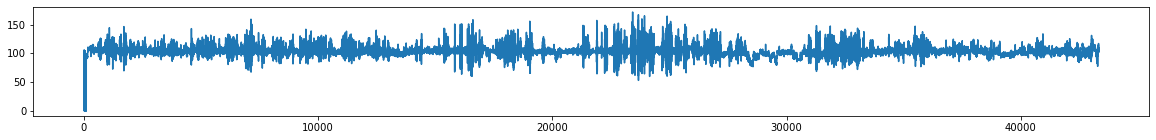

In [353]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([2.9000e+01, 5.8000e+01, 3.1891e+04, 7.9220e+03, 2.7120e+03,
        5.7500e+02, 0.0000e+00, 9.1000e+01, 2.8000e+01, 1.1000e+01,
        4.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([15.  , 15.85, 16.7 , 17.55, 18.4 , 19.25, 20.1 , 20.95, 21.8 ,
        22.65, 23.5 , 24.35, 25.2 , 26.05, 26.9 , 27.75, 28.6 , 29.45,
        30.3 , 31.15, 32.  ]),
 <BarContainer object of 20 artists>)

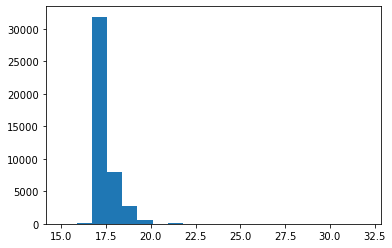

In [354]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [355]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((43330, 100, 640, 3), (43330, 5), (43330, 16), (43330,))

(array([   54.,   311.,  1555.,  3635.,  8750., 22859.,  3623.,  2034.,
          468.,    41.]),
 array([-7720.13739538, -6200.65336518, -4681.16933498, -3161.68530478,
        -1642.20127459,  -122.71724439,  1396.76678581,  2916.25081601,
         4435.73484621,  5955.21887641,  7474.70290661]),
 <BarContainer object of 10 artists>)

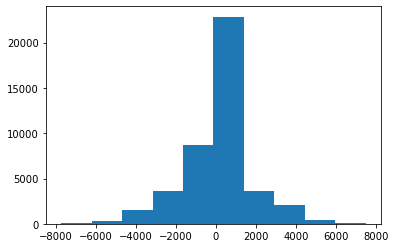

In [356]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([5.0000e+00, 3.5000e+01, 2.0200e+02, 2.2670e+03, 3.3531e+04,
        6.6370e+03, 5.6900e+02, 7.0000e+01, 1.2000e+01, 1.0000e+00]),
 array([-548.3499831 , -431.61499699, -314.88001089, -198.14502479,
         -81.41003869,   35.32494742,  152.05993352,  268.79491962,
         385.52990572,  502.26489183,  618.99987793]),
 <BarContainer object of 10 artists>)

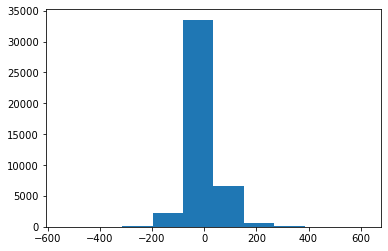

In [357]:
plt.hist(torque[1:]-torque[:-1])

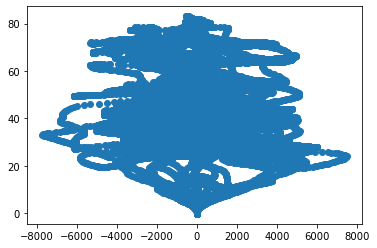

In [358]:
plt.scatter(torque, aux[:,2])

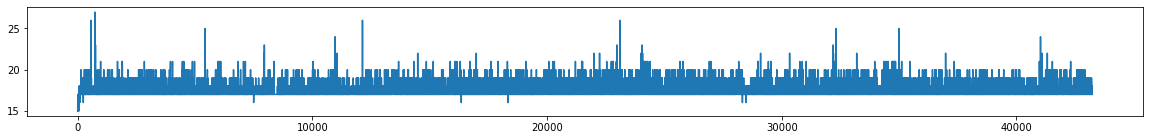

In [359]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

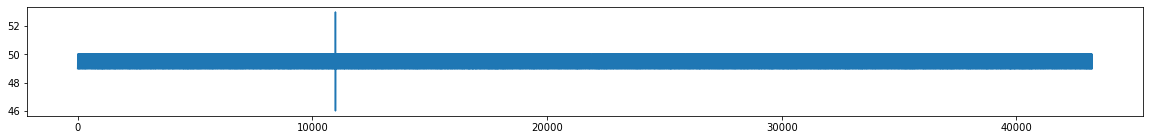

In [360]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

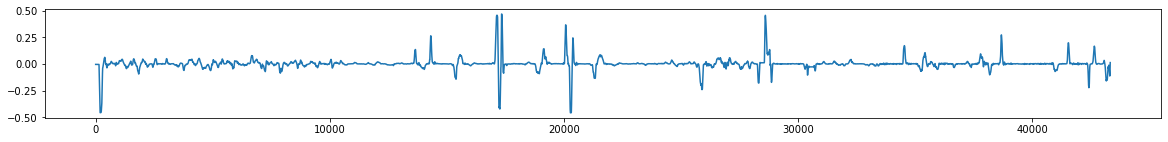

In [361]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [362]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

(array([  217.,    49.,   166.,   595., 30899., 10423.,   523.,   222.,
           89.,   147.]),
 array([-0.45978517, -0.36694457, -0.27410396, -0.18126335, -0.08842274,
         0.00441787,  0.09725848,  0.19009909,  0.28293969,  0.3757803 ,
         0.46862091]),
 <BarContainer object of 10 artists>)

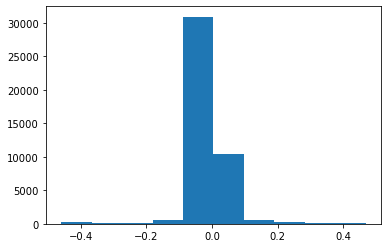

In [363]:
plt.hist(steer_angle)

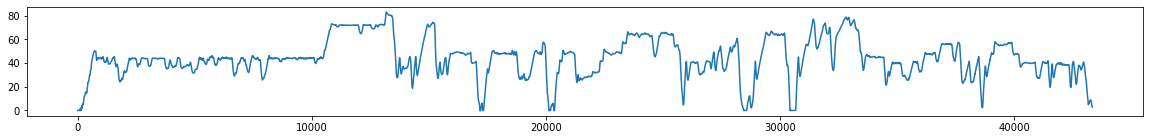

In [364]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([ 1733.,   671.,   989.,  5266.,  9441., 13469.,  3856.,  3546.,
         3606.,   753.]),
 array([-0.3647,  7.984 , 16.33  , 24.69  , 33.03  , 41.38  , 49.72  ,
        58.06  , 66.44  , 74.75  , 83.1   ], dtype=float16),
 <BarContainer object of 10 artists>)

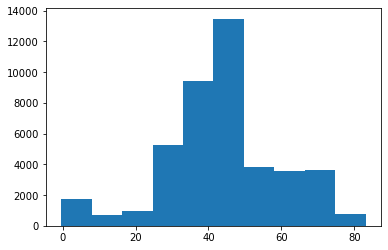

In [365]:
# speed
plt.hist(aux[:,2])

In [366]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), steer_angle is a linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

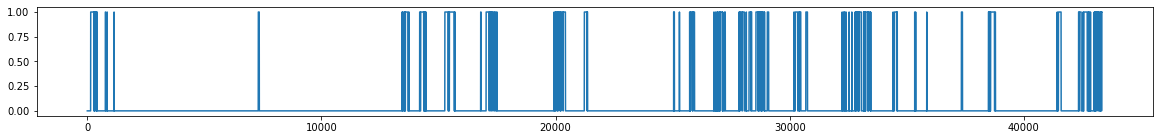

In [367]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([17717054.,  4674513.,  8673240., 10068662., 14205802., 15393636.,
        16544439., 24720766., 23501964.,  3187924.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

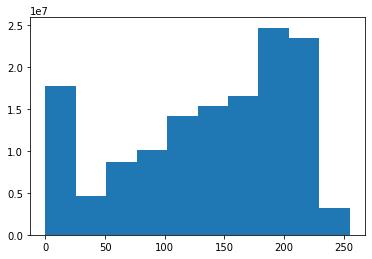

In [368]:
plt.hist(img[::20,:,:,2].flatten())

In [369]:
img.mean()

150.64967060915743

In [370]:
"""for i in range(len(img)):
    img[i] = gamma_correct_auto(img[i])"""

'for i in range(len(img)):\n    img[i] = gamma_correct_auto(img[i])'

<BarContainer object of 10 artists>

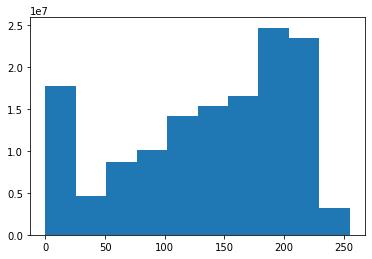

In [371]:
plt.hist(img[::20,:,:,2].flatten())[2]

In [372]:
"""for i in range(len(img)):
    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    
    aux[i, 2] = 80"""

'for i in range(len(img)):\n    img[i] = img[0] #np.concatenate([img[0].mean(axis=-1, keepdims=True) for _ in range(3)], axis=-1)    \n    aux[i, 2] = 80'

In [373]:
aux[:,0] = -.5
aux[:,1] = .5

In [374]:
aux.shape

(43330, 5)

In [375]:
rollout_data = make_vid(run_id, model_stem, img, aux)

(43330, 30) (43330, 1, 13, 80) (43330, 1, 13, 80)
Made vid!


In [376]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

In [377]:
wp_angles_all.shape

(43330, 30)

In [378]:
m_angles = gather_preds(wp_angles_all, aux[:,2])

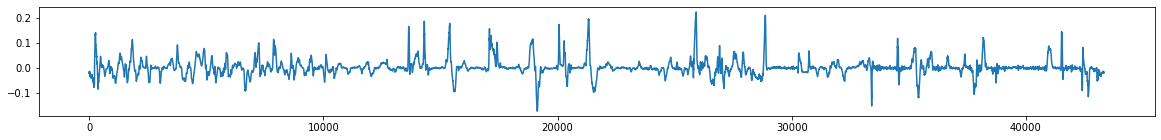

In [379]:
plt.figure(figsize=(20,2))
plt.plot(m_angles)

In [380]:
angles_delta = (m_angles[:-1] - m_angles[1:])

In [381]:
t = angles_delta * (aux[1:,2])**2 # somewhere btwn 6 and 10, of course the lower the better
# do injection testing at that range, see how recoverable it is. Can also make slightly variable by speed,
# as what i'm most scared of is at high speeds

(array([   47.,    87.,   409.,  2308., 18817., 18743.,  2372.,   419.,
           73.,    54.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

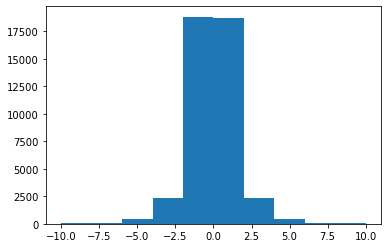

In [382]:
plt.hist(np.clip(t, -10, 10))

In [383]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(t)), y=t, width=900, height=400)
fig.show()

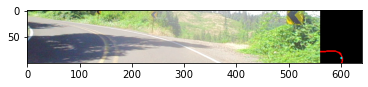

In [384]:
plt.imshow(img[21_540])

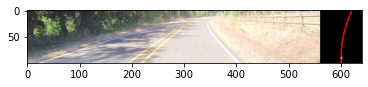

In [385]:
plt.imshow(img[11_800])

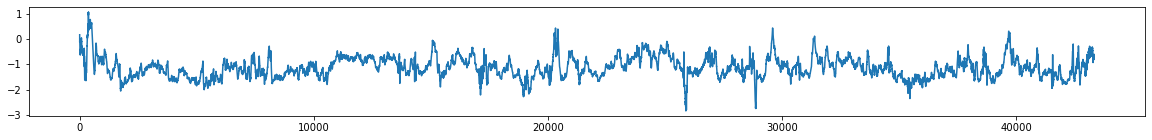

In [386]:
# pitch
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])

In [387]:
obsnet_outs[:,1][:].mean()

-1.126

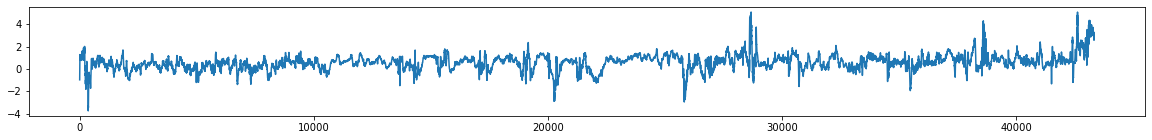

In [388]:
# yaw
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,2])

In [389]:
obsnet_outs[:,2][:].mean()

0.5767

In [391]:
%%time
combine_vids(model_stem, "8.18_avgOldCcs", run_id)

combined!
CPU times: user 2min 6s, sys: 1.43 s, total: 2min 8s
Wall time: 2min 8s


In [420]:
def linear_to_cos(p):
    # p is linear from 0 to 1. Outputs smooth values from 0 to 1 to back to zero
    return (np.cos(p*np.pi*2)*-1 + 1) / 2

In [426]:
def linear_to_sin_decay(p):
    # p is linear from 0 to 1. Outputs smooth values from 1 to 0
    return np.sin(p*np.pi+np.pi/2) / 2 + .5

def linear_to_sin(p):
    # p is linear from 0 to 1. Outputs smooth values from 1 to 0
    return (np.sin(p*np.pi+np.pi/2) / 2 + .5)*-1 + 1

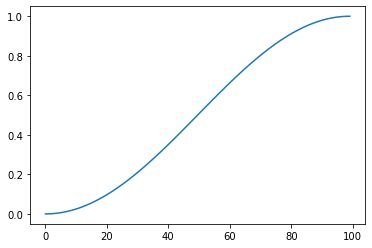

In [427]:
plt.plot([linear_to_sin(p) for p in np.linspace(0, 1.,100)])

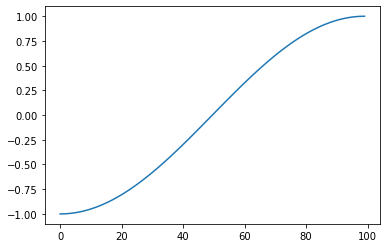

In [411]:
plt.plot([np.sin(p) for p in np.linspace(-3.14/2, 3.14/2,100)])

In [412]:
np.pi / 2

1.5707963267948966

In [414]:
mph_to_mps(45)

20.1168

In [417]:
3.6*.53

1.9080000000000001